# Methods - Analyzing ClearMap's Ilastik Methodology

### Setting
1. Task: We are given $z$ 3D TIFF slices generated by a Python script, with each TIFF slice z-dimension being an array of $x$ by $y$ with values ranging from 0 to 255. We want to estimate the number of cell bodies in a given area and a given number of the $z$ slices.  
2. Loss function: We will evaluate loss through a percent-error analysis [ie: observed less expected over expected]. What this entails is after we receive the "true" number of cell counts from Ailey for a given region, we'll compare the results from our classifier to see whether or not we are near the expected results.
3. Statistical goal: Learn a classifier that distinguishes cell bodies [minimizes O-E/E].
4. Desiderata: We desire a classifier that:  
    i. Estimates the number of cells in a given image to a reasonable degree of accuracy  
    ii. Empirically performs well on the real data  
    iii. Is fast, computationally-speaking  
    iv. Is easy to use  


### Approach

First, we'll analyze ClearMap's Ilastik Python source code to discern if the methods entailed therein differ at all from Ilastik's pixel-classifier methods for generating cell counts.  Then, from there, we'll either do an analysis of how ClearMap generates the pixel-classifier.

### Pseudocode Analysis

Analysis on: https://github.com/ChristophKirst/ClearMap/blob/master/ClearMap/ImageProcessing/IlastikClassification.py  
[ClearMap Ilastik Classification Script]  

From the analysis of the code, the Ilastik script does two different things:  
1.  classifyPixel  
2.  classifyCells  

![classifyPixel](classifyPixel.png)
![classifyCells](classifyCell.png)


### Ilastik Analysis
Since the ClearMap Ilastik module just runs an Ilastik pixel classifier, the ClearMap Ilastik part's methodology is no different than what we did in the past in generating 3D pixel classifiers in Ilastik.  As a brief refresher on what happened then, the last attempts made using Ilastik on Ailey's data proved inconclusive.  I went over this in detail with Greg on 11/4 at office hours - we realized that the pixel classifier that I was making was failing because the Aut data that we had access to wasn't high enough resolution to distinguish cell bodies (the image quality was at a macroscopic level).  We were able to follow the ndio tutorials to select a subset of the image/download some of the data, but we were only able to get the resolution 5 image data.

Note, however, that while the ClearMap Ilastik method just runs Ilastik, the Ilastik method is incorporated into the other parts of the ClearMap pipeline.  The pipeline takes the generated pixel probabilities/class labels and runs additional processing steps (eg: there are additional parameters, like removing background processing, etc). The ClearMap process recommends at LEAST 32 gigabytes of RAM for processing (it recommends 128 GB) -- since Cortex only has 3 GB of free RAM, and since the my deliverable is mainly to analyze the efficacy of the Ilastik pixel module, I used the desktop version of Ilastik on my computer.

### Evaluation
As recommended during our meeting on January 30, I've run these on sample data.  I then plotted the pixel probabilities for random points.

### Results

**Where it should work well:**
The pixel classification workflow is especially robust if the objects of interests are visually (brightness, color, texture) distinct from their surrounding. The algorithm is applicable for a wide range of segmentation problems that fulfill these properties (ie - example data from Janelia, FlyEM project).

![goodExample](goodExample.png)

**Where it should work poorly:**
Obviously, if the borders are unclear or if it's difficult to discern textural differences between objects, it may be very difficult to segment the image (ie - like our current resolution Ailey data [shown here is a sample of a small cutout of the resolution 0 image]).

![poorExample](poorExample.png)

### Analysis

In [1]:
## After running through the same previous steps used in generating a pixel classifier, we obtain
## a numpy array showing the likelihoods of a pixel being in a given label.
%matplotlib inline

import os
import numpy as np

In [89]:
good_probability = np.load("goodprobability.npy");
bad_probability = np.load("badderprobabilities.npy");

In [90]:
print good_probability.shape
print bad_probability.shape

(250, 250, 250, 2)
(5, 250, 250, 2)


In [12]:
## Plot "good" probability density

from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [26]:
xs = [];
ys = [];
zs = [];
the_fourth_dimension = [];

for i in range(10):
    print i
    for j in range(250):
        for k in range(250):
            xs = np.append(xs, i);
            ys = np.append(ys, j);
            zs = np.append(zs, k);
            the_fourth_dimension = np.append(the_fourth_dimension, good_probability[i, j, k]);

0
1
2
3
4
5
6
7
8
9


In [27]:
print "subset complete"

subset complete


In [44]:
## Generate 5000 random points

import random

randX = [];
randY = [];
randZ = [];

for i in range(5000):
    randX = np.append(randX, random.randrange(0, 250, 1))
    randY = np.append(randY, random.randrange(0, 250, 1))
    randZ = np.append(randZ, random.randrange(0, 250, 1))

In [51]:
outputColors = [];
    
for j in range(5000):
    outputColors = np.append(outputColors, good_probability[randX[j], randY[j], randZ[j]])

/Users/Tony/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


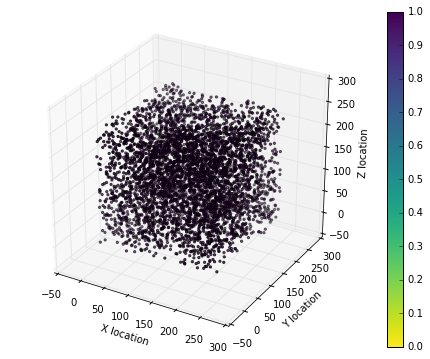

In [69]:
## Plot 5000 of the random points.

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

colors = cm.viridis_r(outputColors/max(outputColors))

colmap = cm.ScalarMappable(cmap=cm.viridis_r)
colmap.set_array(outputColors)

yg = ax.scatter(randX, randY, randZ, c=colors, marker='.')
cb = fig.colorbar(colmap)

ax.set_xlabel('X location')
ax.set_ylabel('Y location')
ax.set_zlabel('Z location')

plt.show()

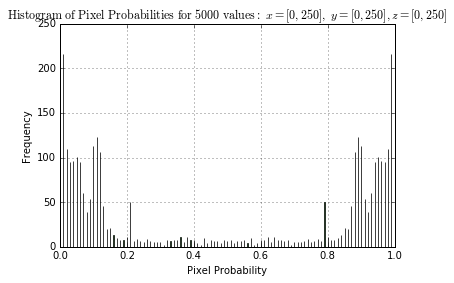

In [71]:
## Plot the pixel likelihood histogram, showing the distribution of likelihoods.

n, bins, patches = plt.hist(outputColors, 5000, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Pixel Probability')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of\ Pixel\ Probabilities\ for\ 5000\ values:}\ x = [0, 250],\ y = [0, 250], z = [0, 250]$')
plt.grid(True)
plt.axis([0, 1, 0, 250])

plt.show()

In [91]:
print bad_probability.shape

(5, 250, 250, 2)


In [92]:
## Generate 5000 random points for the bad example

randXBad = [];
randYBad = [];
randZBad = [];

for i in range(5000):
    randXBad = np.append(randXBad, random.randrange(0, 5, 1))
    randYBad = np.append(randYBad, random.randrange(0, 250, 1))
    randZBad = np.append(randZBad, random.randrange(0, 250, 1))

outputColorsBad = [];
    
for j in range(5000):
    outputColorsBad = np.append(outputColorsBad, bad_probability[randXBad[j], randYBad[j], randZBad[j]])

/Users/Tony/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


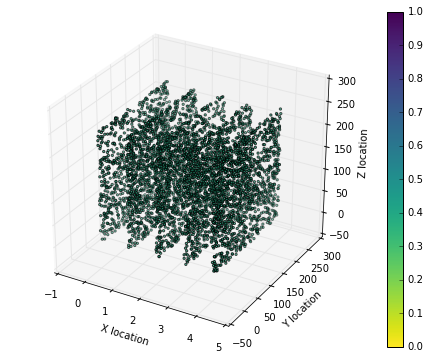

In [93]:
## Plot 5000 of the "bad" random points.

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

colors = cm.viridis_r(outputColorsBad/max(outputColorsBad))

colmap = cm.ScalarMappable(cmap=cm.viridis_r)
colmap.set_array(outputColorsBad)

yg = ax.scatter(randXBad, randYBad, randZBad, c=colors, marker='.')
cb = fig.colorbar(colmap)

ax.set_xlabel('X location')
ax.set_ylabel('Y location')
ax.set_zlabel('Z location')

plt.show()

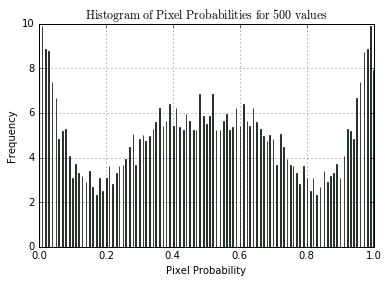

In [94]:
## Plot the pixel likelihood histogram, showing the distribution of likelihoods.

n, bins, patches = plt.hist(outputColorsBad, 500, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Pixel Probability')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of\ Pixel\ Probabilities\ for\ 500\ values}$')
plt.grid(True)

plt.show()

### How well did it work?
From the histogram, it appears that the good data classifier responded was able to distinguishing between areas that were cells versus those that were not cells (ie: we don't see a significant population of pixels that the classifier was unsure about, or the frequency between 0.2 and 0.8 is low).  From the 3D PyPlot, however, we can't really see any areas or clearly demarked boundaries, although that's moreso to do with the plotting technique than anything else.  For the unclear results, clearly something wasn't going right -- the pixel classifier was not confident.